In [11]:
import os
import json
import numpy as np
import torch as th
import motornet as mn
import pickle
import matplotlib.pyplot as plt

from my_policy import Policy  # the RNN
from my_task import CentreOutFF  # the task
from my_loss import cal_loss  # the loss function
from my_utils import (
    save_model,
    print_losses,
    plot_stuff,
    run_episode,
    test,
    plot_training_log,
    plot_simulations,
    plot_activation,
    plot_kinematics,
)  # utility functions
print("All packages imported.")
print("pytorch version: " + th.__version__)
print("numpy version: " + np.__version__)
print("motornet version: " + mn.__version__)

All packages imported.
pytorch version: 2.5.1
numpy version: 2.1.3
motornet version: 0.2.0


In [12]:
model_name = "m0"
data = test(
        "models/" + model_name + "/" + model_name + "_cfg.json",
        "models/" + model_name + "/" + model_name + "_weights",
    )[0]
print(data.keys())

dict_keys(['xy', 'obs', 'tg', 'vel', 'all_actions', 'all_hidden', 'all_muscle', 'all_force'])


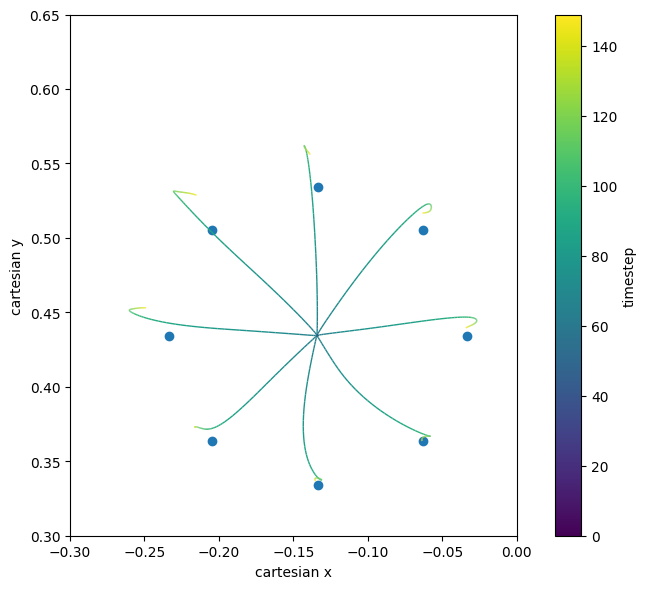

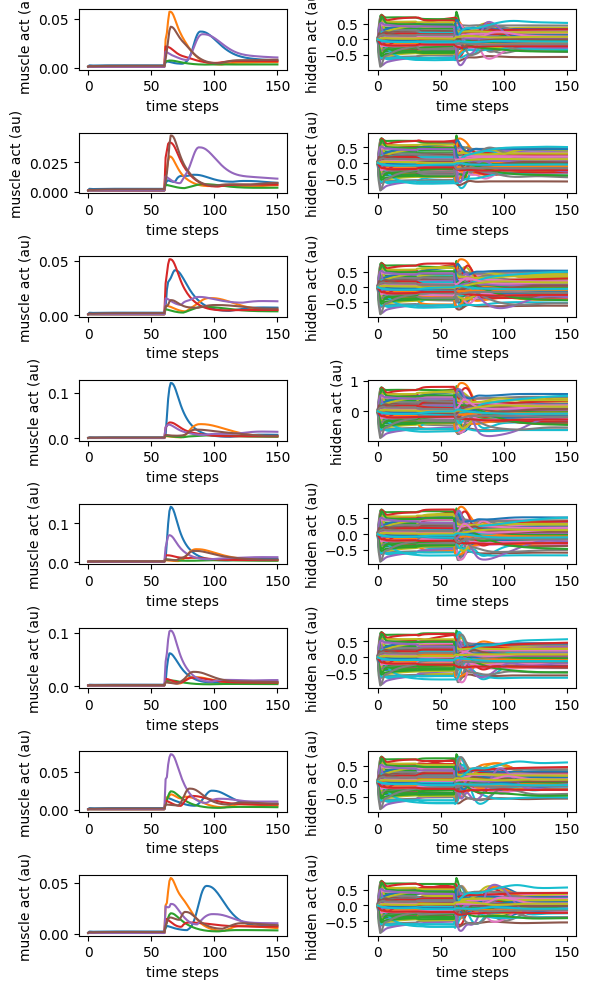

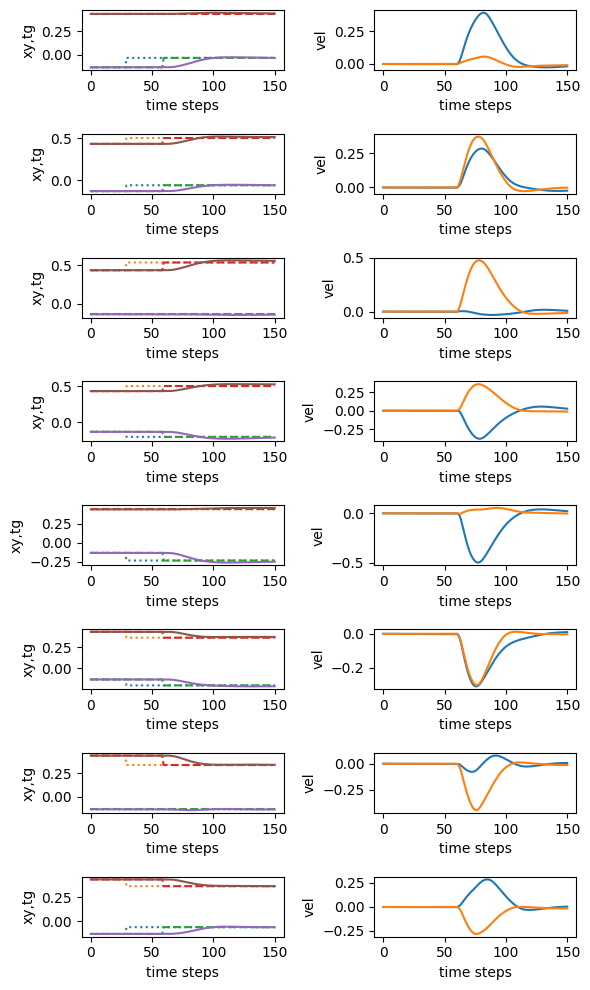

In [13]:
fig, ax = plot_simulations(xy=data["xy"], target_xy=data["tg"], figsize=(8, 6))
fig, ax = plot_activation(data["all_hidden"], data["all_muscle"])
fig, ax = plot_kinematics(all_xy=data["xy"], all_tg=data["tg"], all_vel=data["vel"], all_obs=data["obs"])

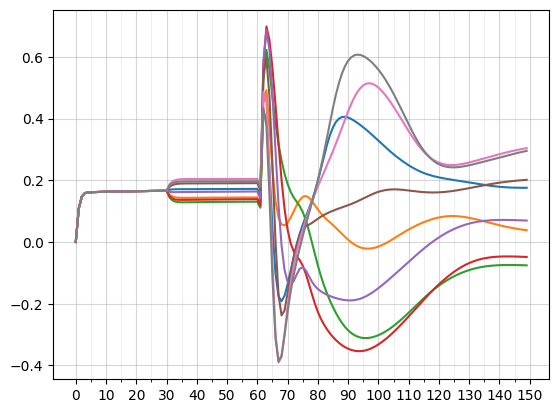

In [14]:
h = data["all_hidden"][:,:,0].T # [tgt,time,neuron]
n_time = np.shape(h)[0]
time = np.arange(0,n_time,1)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time,h)
major_ticks = np.arange(0, 151, 10)
minor_ticks = np.arange(0, 151, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()

/var/folders/02/x_b2h5mx1v5fqxfnpnt82kz80000gn/T/ipykernel_7835/47062559.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hh = h - np.tile(h0,[n_time,1])


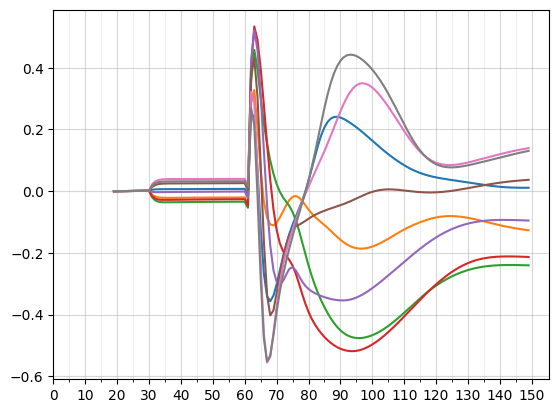

In [15]:
n_tgt = 24 # 1 timestep before the target shifts
n_win = 5
h0 = th.mean(h[n_tgt-n_win:n_tgt,:], axis=0) # mean hidden activity over n_win timesteps up to tgt shift
hh = h - np.tile(h0,[n_time,1])
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time[n_tgt-n_win:], hh[n_tgt-n_win:])
major_ticks = np.arange(0, 151, 10)
minor_ticks = np.arange(0, 151, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()